In [1]:
# General tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas_profiling as pp

from datetime import date

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt

# # For the tree visualization
# import pydot
# from IPython.display import Image
# from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse

# For validation
from sklearn.model_selection import train_test_split as split

# regular expressions
import re 

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **EDA**

*/kaggle/input/craigslist-carstrucks-data/vehicles.csv*

In [127]:
#reading the file and looking at the data
# data = pd.read_csv('/content/vehicles.csv')
# ,quoting=csv.QUOTE_NONE header = None, delimiter="\t", , encoding='utf-8'
csvfile = '/content/drive/MyDrive/naya-2022/vehicle1s.csv'
df = pd.read_csv(csvfile, engine="python", error_bad_lines=False)

# df.tail()
# df.info()
# df.describe()
df.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


(426880, 17)

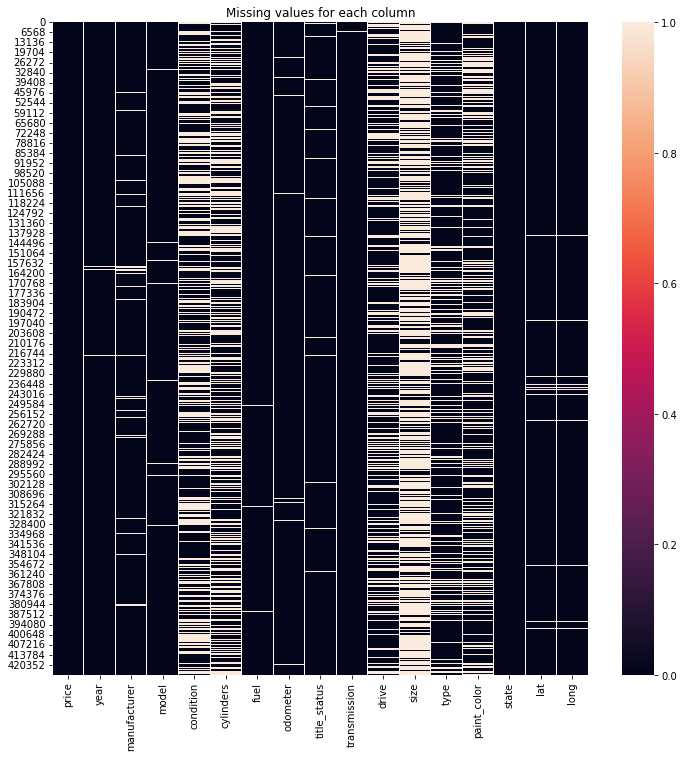

In [4]:
# Display the missing values
plt.figure(figsize=(12,12))
plt.title("Missing values for each column")
sns.heatmap(df.isnull())
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Types of Cylinders')

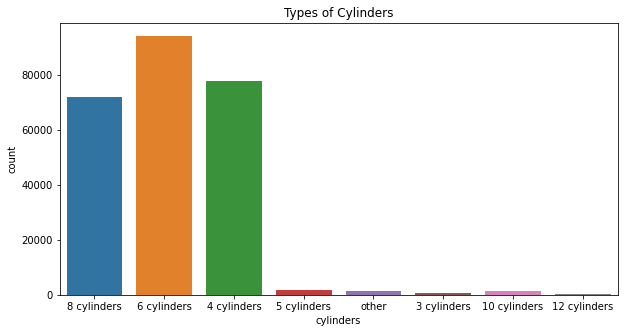

In [39]:
plt.figure(figsize=(10,5))
sns.countplot(df['cylinders'])
plt.title('Types of Cylinders')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


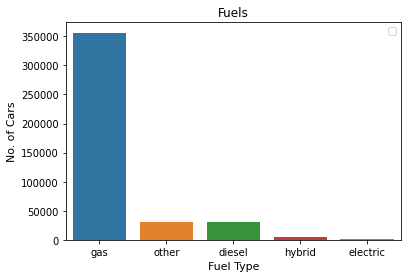

In [40]:
graph = sns.countplot(df['fuel'])
graph.set_xlabel('Fuel Type',size=11)
graph.set_ylabel('No. of Cars',size=11)
plt.title('Fuels')
plt.legend()

# **Data Preprocessing**

In [128]:
# Dropping rows with missing cylinders, transmission and drive
df.drop(df[(df['cylinders'].isna()) & (df['transmission'].isna()) & (df['model'].isna())].index, inplace = True)
df['cylinders'] = df['cylinders'].apply(lambda x: x.split()[0] if not pd.isnull(x) else np.nan)
# Dropping rows with missing condition with price
df.drop(df[(df['condition'].isna()) & (df['price'].isna())].index, inplace = True)

# Changing cylinders of tesla cars to 0
df.loc[df.manufacturer == 'tesla', 'cylinders'] = 0
df.cylinders.fillna(0, inplace = True)
df.cylinders =  df.cylinders.replace('other', 0)

values = {"fuel": 'other', "cylinders": 'other', 'drive': 'other', 'size': 'other', 'type': 'other', 'model':'other', 'condition':'other', 'paint_color':'other'}
df.fillna(value=values, inplace=True)

print(df.shape)

(426796, 17)


In [129]:
#removing unimportant collumns and checking the row count
# data = df.drop(columns=['county','url','region','region_url','VIN','image_url','description','id','lat','long','posting_date','fuel','transmission',
#               'drive','size','type','paint_color','state'])
# data.shape

data = df[df['title_status']=='clean']
data = data.drop(columns=['state','lat','long','title_status'])

# Imputing missing values in odometer with median odometer of each year cars
year_med =  dict(data.groupby('year')['odometer'].median())
print(year_med)
data['odometer'] = data['odometer'].fillna(data['year'].apply(lambda x: year_med.get(x)))

# data.loc[data['year'].isnull()]
data = data.drop(data[(data['year'].isnull())].index)

print(data.shape)

{1900.0: 4500.0, 1901.0: 1.0, 1903.0: nan, 1905.0: 202570.0, 1910.0: 50.5, 1913.0: 5000074.5, 1915.0: 12345.0, 1916.0: 6008.0, 1918.0: 56000.0, 1920.0: 55532.5, 1921.0: 605.5, 1922.0: 80000.0, 1923.0: 2500.0, 1924.0: 15158.0, 1925.0: 340.0, 1926.0: 1234.0, 1927.0: 5557.0, 1928.0: 14500.0, 1929.0: 8500.0, 1930.0: 2100.0, 1931.0: 11010.0, 1932.0: 7067.0, 1933.0: 5830.0, 1934.0: 9356.5, 1935.0: 12345.0, 1936.0: 38000.0, 1937.0: 15600.0, 1938.0: 47475.5, 1939.0: 6100.0, 1940.0: 6226.0, 1941.0: 20795.5, 1942.0: 12700.0, 1943.0: 8800.0, 1944.0: 22250.0, 1945.0: 500000.5, 1946.0: 37500.0, 1947.0: 23910.0, 1948.0: 27293.5, 1949.0: 48000.0, 1950.0: 53963.0, 1951.0: 42000.0, 1952.0: 8992.5, 1953.0: 49500.0, 1954.0: 42086.0, 1955.0: 20000.0, 1956.0: 39500.0, 1957.0: 16100.0, 1958.0: 71000.0, 1959.0: 61000.0, 1960.0: 42000.0, 1961.0: 45000.0, 1962.0: 50000.0, 1963.0: 68711.5, 1964.0: 64000.0, 1965.0: 61009.0, 1966.0: 64000.0, 1967.0: 50000.0, 1968.0: 47000.0, 1969.0: 56000.0, 1970.0: 56000.0, 1971

In [130]:
# manufactories = ['gmc', 'chevrolet', 'toyota', 'ford', 'jeep', 'nissan', 'ram',
#        'honda', 'dodge', 'chrysler', 'lincoln', 'subaru', 'acura',
#        'mercedes-benz', 'infiniti', 'bmw', 'volkswagen', 'mazda',
#        'porsche', 'lexus', 'kia', 'ferrari', 'audi', 'mitsubishi',
#        'pontiac', 'hyundai', 'fiat', 'cadillac', 'rover', 'jaguar',
#        'mini', 'saturn', 'volvo', 'alfa-romeo', 'buick', 'mercury']

manufactories = {k: v for v, k in enumerate(data.manufacturer.unique())}
data['manufacturer_id'] = data['manufacturer'].map(manufactories).fillna('other')
# print(manufactories)
# print(data)

In [ ]:
# df.loc[(df['transmission'].isna()) | (df['transmission'].isnull())]

In [131]:
# Remove 'Junk' prices
data.fuel.fillna('gas', inplace = True)

data0 = data[data['price'].map(
        lambda par: par not in (1234, 12340, 12344, 12345, 12349, 123456, 1234567, 12345678, 123456789, 1234567890, 9999, 999999, 99999999,
                                1111, 11111, 11117, 111111, 1111111, 11111111, 1111111111, 2222, 22222, 3333, 33333))]

data0.drop(data0[(data0['price'] < 2500)].index, inplace = True)
data0.drop(data0[(data0.price > 50000)].index, inplace = True)

data0.drop(data0[(data0['manufacturer'].isnull()) & (data0['model'].isnull())].index, inplace = True)
data0.drop(data0[(data0['model'].isnull())].index, inplace = True)
data0.drop(data0[(data0['year'].isnull())].index, inplace = True)
data0.drop(data0[data0['year'].isna()].index, inplace = True) 

data0['year'] = data0['year'].astype(int)
data0['year'].dtype
data0['age'] = data0.year.apply(lambda x: int(2022-x))

data0.drop(data0[( (data0['model'].isnull())|(data0['manufacturer'].isnull())) & (data0['condition'].isnull())].index, inplace = True) 

# data0 = data0.drop(columns=['cylinders'])
# data0.drop(columns=['manufacturer'], inplace = True) 
# data0 = data0.drop(data0[(data0['odometer'].isnull())].index)
data0.drop(data0[(data0['year'].isnull()) & (data0['model'].isnull()) & (data0['condition'].isnull())].index, inplace = True) 
data0.drop(data0[(data0['year'].isnull())].index, inplace = True) 
data0.drop(data0[(data0['year'] < 1995)].index, inplace = True) 

data0=data0[(data0.odometer < 300000)]

data0['condition'].fillna('missing', inplace=True)
data0.drop(data0[(data0['fuel'].isnull())].index, inplace = True) 
data0.drop(data0[(data0['transmission'].isnull())].index, inplace = True) 
data0['model']=data0['model'].fillna('unknown')

#drop less 1000 miles
data0 = data0.drop(data0[(data0['odometer'] < 1000)].index)
data0 = data0.drop(data0[(data0['manufacturer'].isnull())].index)

# Dropping cars with price less than 1000 with miles less than 60,000 and model year greater than 2010
# data.drop(data[(data.price < 1000 ) & (data.odometer < 60000 ) & (data.year > 2010)].index, inplace = True)

# Changing cylinders of tesla cars to 0
# data.loc[data.manufacturer == 'tesla', 'cylinders'] = '0 cylinders'
# data.cylinders.fillna(-1, inplace = True)
# data.cylinders = data.cylinders.replace('other', -2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

# **Feature Engineering**

In [132]:
# topCarsManuf = ['ford','chevrolet','toyota','honda','jeep','nissan','ram','gmc','bmw','dodge','hyundai','subaru','volkswagen','kia','lexus','mercedes-benz']
# topCarsManuf = ['ford','chevrolet','toyota','honda','jeep']
# data1 = data0[data0['manufacturer'].isin(topCarsManuf)]

data1 = data0.copy()

data1["model_split"] = data1["model"].str.split().str[0] + " " + data1["model"].str.split().str[1]
data1["model_split"]=data1["model_split"].fillna(data1["model"])
data1["model"]=data1["model_split"]
data1

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,manufacturer_id,age,model_split
27,33590,2014,gmc,sierra 1500,good,8,gas,57923.0,other,other,other,pickup,white,0,8,sierra 1500
28,22590,2010,chevrolet,silverado 1500,good,8,gas,71229.0,other,other,other,pickup,blue,1,12,silverado 1500
29,39590,2020,chevrolet,silverado 1500,good,8,gas,19160.0,other,other,other,pickup,red,1,2,silverado 1500
30,30990,2017,toyota,tundra double,good,8,gas,41124.0,other,other,other,pickup,red,2,5,tundra double
31,15000,2013,ford,f-150 xlt,excellent,6,gas,128000.0,automatic,rwd,full-size,truck,black,3,9,f-150 xlt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019,nissan,maxima s,good,6,gas,32226.0,other,fwd,other,sedan,other,5,3,maxima s
426876,30590,2020,volvo,s60 t5,good,0,gas,12029.0,other,fwd,other,sedan,red,14,2,s60 t5
426877,34990,2020,cadillac,xt4 sport,good,0,diesel,4174.0,other,other,other,hatchback,white,8,2,xt4 sport
426878,28990,2018,lexus,es 350,good,6,gas,30112.0,other,fwd,other,sedan,silver,10,4,es 350


In [133]:
condition_slice = ['other','new','salvage']
data1 = data1[~data1['condition'].isin(condition_slice)]
data1.condition.value_counts()

good         101185
excellent     73202
like new      15209
fair           2308
Name: condition, dtype: int64

In [134]:
data0 = data1.copy()

In [135]:
data0.sample(100)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,manufacturer_id,age,model_split
297960,40600,2020,ford,transit t250,excellent,0,gas,17000.0,automatic,other,other,other,white,3,2,transit t250
18861,28590,2017,ram,1500 quad,good,0,other,41816.0,other,4wd,other,pickup,other,6,5,1500 quad
156586,7550,2011,buick,regal cxl,good,4,gas,109000.0,automatic,fwd,mid-size,sedan,black,12,11,regal cxl
187277,9995,2016,hyundai,veloster,excellent,0,gas,101000.0,automatic,fwd,other,coupe,red,22,6,veloster
70539,16988,2017,chevrolet,traverse -,excellent,6,gas,45889.0,automatic,fwd,other,SUV,blue,1,5,traverse -
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413886,5800,2005,toyota,camry,excellent,4,gas,125000.0,automatic,fwd,full-size,sedan,other,2,17,camry
146996,8950,2005,toyota,tundra double,good,8,gas,205765.0,automatic,rwd,full-size,truck,white,2,17,tundra double
219568,12500,2007,pontiac,solstice,like new,4,gas,29138.0,manual,rwd,compact,convertible,black,33,15,solstice
8486,28497,2018,gmc,canyon,excellent,6,gas,26878.0,automatic,other,full-size,pickup,black,0,4,canyon


In [136]:
# Add 'manufacturer_model' column
data0['manufacturer_model'] = data0['manufacturer_id'].apply(str) + "##" + data0['model'].apply(str)

column_names = ['price', 'manufacturer', 'year', 'model','model_split','condition','cylinders','fuel','odometer','transmission','drive','size','type','paint_color','manufacturer_id','age', 'manufacturer_model']
data0 = data0.reindex(columns=column_names)

manufacturer_model = {k: v for v, k in enumerate(data0.manufacturer_model.unique())}
data0['manufacturer_model_id'] = data0['manufacturer_model'].map(manufacturer_model).fillna('other')

# get cars with popular models 
v = data0.manufacturer_model_id.value_counts()
data0 = data0[data0.manufacturer_model_id.isin(v.index[v.gt(50)])]

In [117]:
#creating charts for data understanding
# sns.pairplot(data = data0, diag_kind = 'kde')

In [137]:
data0['manufacturer'].value_counts()

ford             24177
chevrolet        20726
toyota           14787
honda             8661
jeep              7276
nissan            6645
gmc               6379
bmw               5730
ram               5406
dodge             4234
hyundai           4064
volkswagen        3999
lexus             3550
acura             3433
subaru            3382
audi              3374
kia               2910
mercedes-benz     2812
cadillac          2642
chrysler          2247
mazda             2093
infiniti          2060
buick             1980
lincoln           1908
mitsubishi        1390
volvo             1368
mini              1183
alfa-romeo         708
jaguar             707
rover              664
tesla              542
pontiac            493
fiat               367
mercury            265
saturn             239
porsche            150
Name: manufacturer, dtype: int64

# **Data Visualisation**

Text(0, 0.5, 'Modal name')

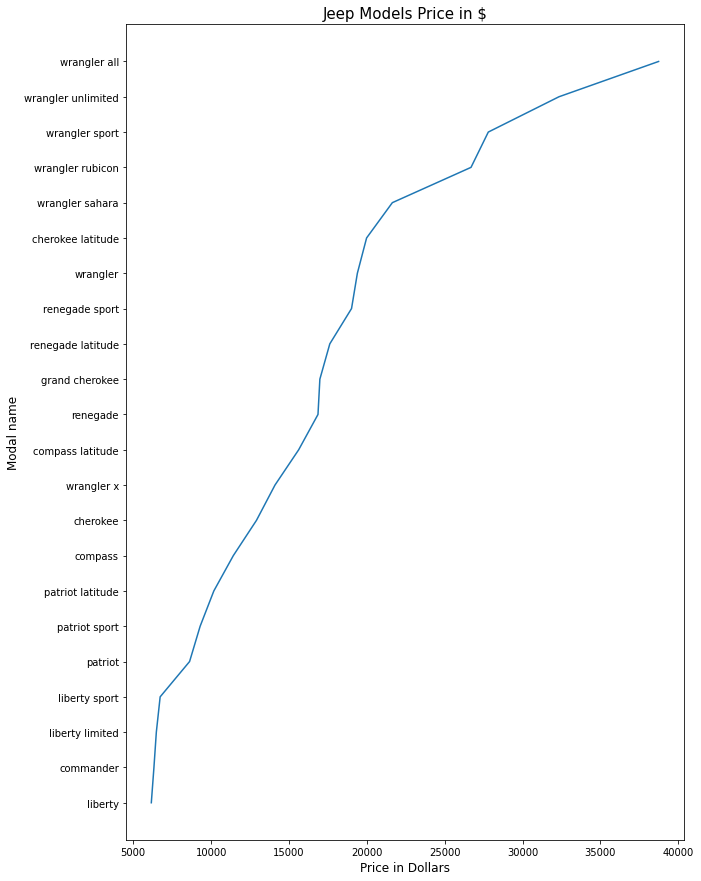

In [138]:
# price_df = data0.groupby(['manufacturer','model'])['price'].mean()
price_df = data0.groupby(['manufacturer','model'])['price'].mean()
price_df

audi_price = price_df.loc['jeep'].reset_index()
audi_price = audi_price.sort_values(by='price',ascending=False)
audi_price.head(10)

plt.figure(figsize=(10,15))
graph = sns.lineplot(y = 'model',x='price',data = audi_price.head(80))
plt.title('Jeep Models Price in $',size=15)
#k = graph.set_xticklabels(graph.get_xticklabels(),rotation=90,size=15)
graph.set_xlabel('Price in Dollars',size=12)
graph.set_ylabel('Modal name',size=12)

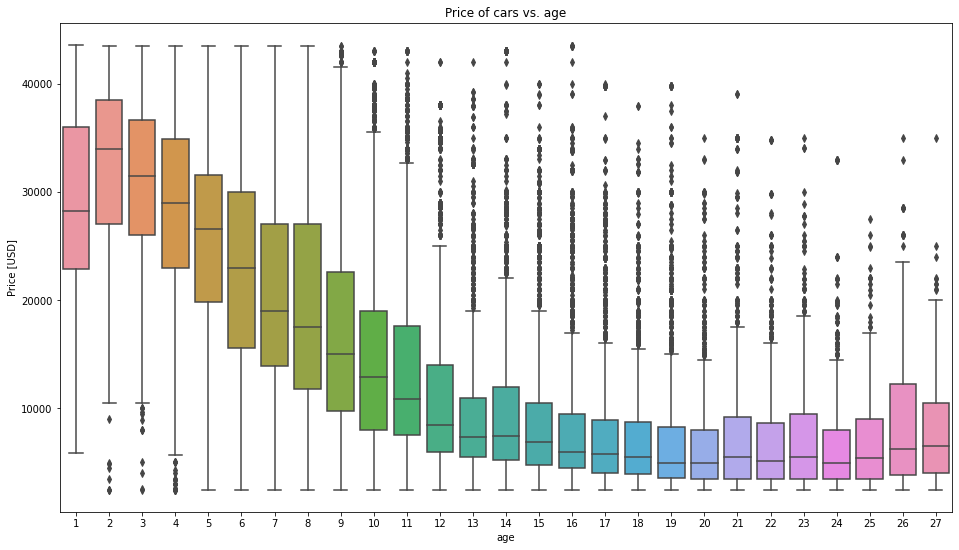

In [139]:
#identifying outliers:
price_over_98pct = data0["price"].quantile(.98)

price_yr_cleaned = data0[(1 < data0["price"]) & (data0["price"] < price_over_98pct) & (data0["age"] != 0) ]

plt.figure(figsize=(16,9))
sns.boxplot(x="age", y="price", data = price_yr_cleaned)
plt.title("Price of cars vs. age")
plt.ylabel("Price [USD]")

max_year = price_yr_cleaned["year"].max()
min_year = price_yr_cleaned["year"].min()
steps = 2
lab = np.sort(price_yr_cleaned["year"].unique())[::2]
pos = np.arange(0,111,2)

# plt.xticks(ticks=pos, labels=lab, rotation=90)
plt.show()

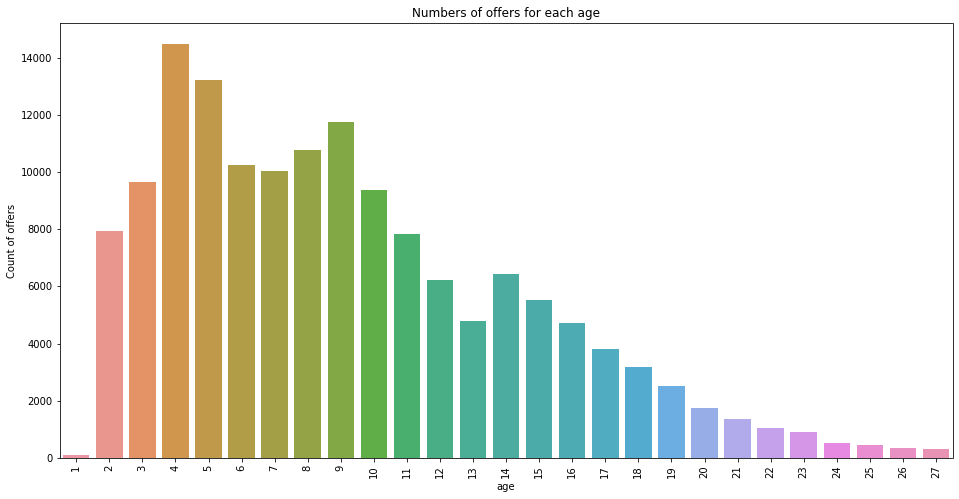

In [140]:
# Number of offers per year
no_of_offers = price_yr_cleaned.groupby("age")["price"].count()

plt.figure(figsize=(16,8))
sns.barplot(x = no_of_offers.index, y = no_of_offers.values)
plt.title("Numbers of offers for each age")
plt.ylabel("Count of offers")
plt.xticks(rotation=90)
plt.show()

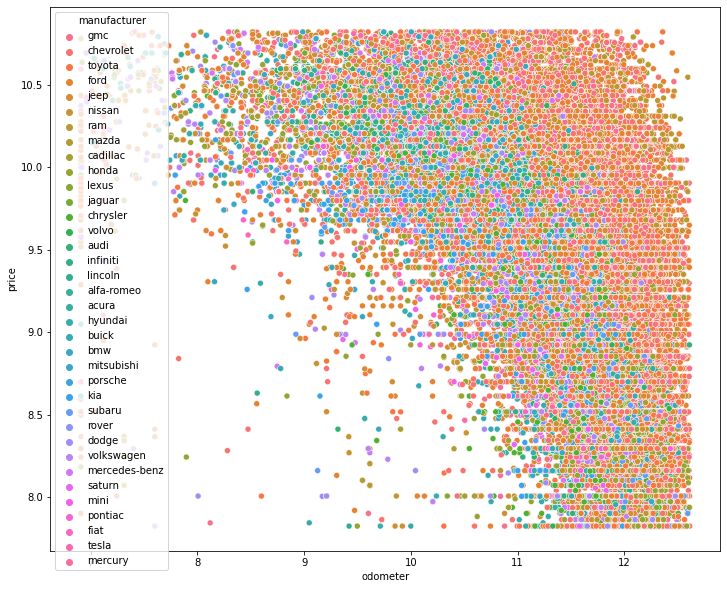

In [141]:
# data_model = data0[data0['manufacturer'].isin(['ford','chevrolet','toyota'])].copy()
data_model = data0.copy()

data_model['price'] = np.log1p(data_model['price'])
data_model['odometer'] = np.log1p(data_model['odometer'])

plt.figure(figsize=[12,10])
ax = sns.scatterplot(x="odometer", y="price", hue="manufacturer",data=data_model)

In [151]:
data_test_regression = data_model.drop(columns=['model','paint_color','manufacturer_id','manufacturer_model','model_split']).copy()
# data_test_regression = data_model.drop(columns=['model','paint_color','manufacturer_id','manufacturer_model']).copy()
data_test_regression

,price,manufacturer,year,condition,cylinders,fuel,odometer,transmission,drive,size,type,age,manufacturer_model_id
27,10.422013,gmc,2014,good,8,gas,10.966887,other,other,other,pickup,8,0
28,10.025307,chevrolet,2010,good,8,gas,11.173669,other,other,other,pickup,12,1
29,10.586357,chevrolet,2020,good,8,gas,9.860632,other,other,other,pickup,2,1
30,10.341452,toyota,2017,good,8,gas,10.624371,other,other,other,pickup,5,2
31,9.615872,ford,2013,excellent,6,gas,11.759793,automatic,rwd,full-size,truck,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426874,10.422013,lexus,2018,good,6,gas,10.335757,automatic,rwd,other,sedan,4,575
426876,10.328461,volvo,2020,good,0,gas,9.395159,other,fwd,other,sedan,2,39
426877,10.462846,cadillac,2020,good,0,diesel,8.336870,other,other,other,hatchback,2,22
426878,10.274741,lexus,2018,good,6,gas,10.312712,other,fwd,other,sedan,4,280


In [152]:
# lable with index
categoricals = [
    'condition','cylinders','fuel','transmission','drive','size','type','manufacturer'
]
categories_values = []

for cat in categoricals:
    data_test_regression[cat] = data_test_regression[cat].astype('category')
    categories_values.append(dict(enumerate(data_test_regression[cat].cat.categories)))
    data_test_regression[cat] = data_test_regression[cat].cat.codes

data_test_regression

,price,manufacturer,year,condition,cylinders,fuel,odometer,transmission,drive,size,type,age,manufacturer_model_id
27,10.422013,11,2014,2,7,2,10.966887,2,2,3,8,8,0
28,10.025307,6,2010,2,7,2,11.173669,2,2,3,8,12,1
29,10.586357,6,2020,2,7,2,9.860632,2,2,3,8,2,1
30,10.341452,33,2017,2,7,2,10.624371,2,2,3,8,5,2
31,9.615872,10,2013,0,6,2,11.759793,0,3,1,10,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426874,10.422013,18,2018,2,6,2,10.335757,0,3,3,9,4,575
426876,10.328461,35,2020,2,0,2,9.395159,2,1,3,9,2,39
426877,10.462846,5,2020,2,0,0,8.336870,2,2,3,4,2,22
426878,10.274741,18,2018,2,6,2,10.312712,2,1,3,9,4,280


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


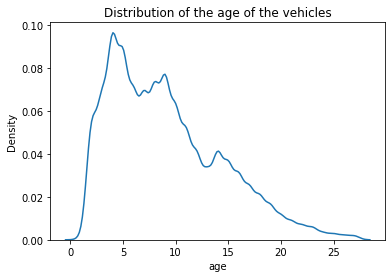

In [153]:
sns.distplot(data_test_regression.age, hist = False)
plt.title("Distribution of the age of the vehicles")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


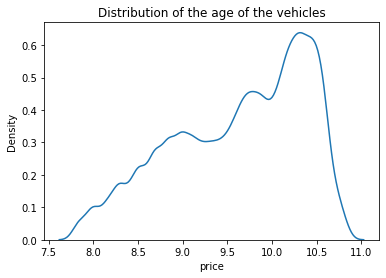

In [154]:
sns.distplot(data_test_regression.price, hist = False)
plt.title("Distribution of the age of the vehicles")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


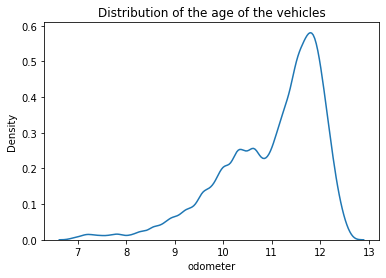

In [155]:
sns.distplot(data_test_regression.odometer, hist = False)
plt.title("Distribution of the age of the vehicles")
plt.show()

# **Training set and test set**

In [156]:
yy = data_test_regression['price']
XX = data_test_regression.drop(['price','year','fuel','manufacturer'], axis=1)
# XX = data_test_regression.drop(['price','manufacturer_model_id','year','fuel','drive','size','manufacturer'], axis=1)
print(XX.dtypes)
XX = pd.get_dummies(XX, columns=["condition","size","drive","type"])

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.30, random_state=42)

XX

condition                   int8
cylinders                   int8
odometer                 float64
transmission                int8
drive                       int8
size                        int8
type                        int8
age                        int64
manufacturer_model_id      int64
dtype: object


,cylinders,odometer,transmission,age,manufacturer_model_id,condition_0,condition_1,condition_2,condition_3,size_0,size_1,size_2,size_3,size_4,drive_0,drive_1,drive_2,drive_3,type_0,type_1,type_2,type_3,type_4,type_5,type_6,type_7,type_8,type_9,type_10,type_11,type_12
27,7,10.966887,2,8,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
28,7,11.173669,2,12,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
29,7,9.860632,2,2,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
30,7,10.624371,2,5,2,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
31,6,11.759793,0,9,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426874,6,10.335757,0,4,575,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
426876,0,9.395159,2,2,39,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
426877,0,8.336870,2,2,22,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
426878,6,10.312712,2,4,280,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


  # **KNeighborsRegressor**

RMSE value for k=  2 is: 0.23844288775730352
RMSE value for k=  3 is: 0.23546937673002769
RMSE value for k=  4 is: 0.2359843223285485
RMSE value for k=  5 is: 0.23650991908752103
RMSE value for k=  6 is: 0.23785518858092325
RMSE value for k=  7 is: 0.23936421135438743


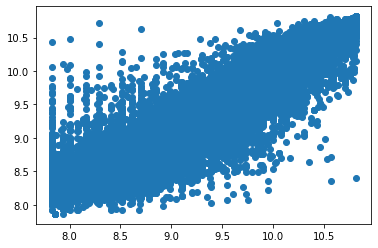

In [164]:
#import required packages

%matplotlib inline

rmse_val = [0] #to store rmse values for different k
for K in range(2,8):
    model = neighbors.KNeighborsRegressor(n_neighbors = K, metric='euclidean')
    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mse(y_test, pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

plt.scatter(y_test,pred)

In [158]:
XX

,cylinders,odometer,transmission,age,manufacturer_model_id,condition_0,condition_1,condition_2,condition_3,size_0,size_1,size_2,size_3,size_4,drive_0,drive_1,drive_2,drive_3,type_0,type_1,type_2,type_3,type_4,type_5,type_6,type_7,type_8,type_9,type_10,type_11,type_12
27,7,10.966887,2,8,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
28,7,11.173669,2,12,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
29,7,9.860632,2,2,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
30,7,10.624371,2,5,2,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
31,6,11.759793,0,9,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426874,6,10.335757,0,4,575,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
426876,0,9.395159,2,2,39,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
426877,0,8.336870,2,2,22,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
426878,6,10.312712,2,4,280,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


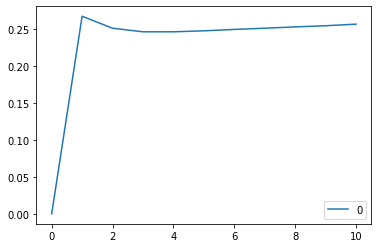

In [92]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

# **Linear Regression**

In [159]:
# X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.30, random_state=42)

from sklearn.metrics import mean_squared_error as mse
LinearRegresion_model_cars = LinearRegression().fit(XX, yy)
result_df = data_test_regression.copy()
result_df['price pred'] = LinearRegresion_model_cars.predict(XX)
result_df.head()

,price,manufacturer,year,condition,cylinders,fuel,odometer,transmission,drive,size,type,age,manufacturer_model_id,price pred
27,10.422013,11,2014,2,7,2,10.966887,2,2,3,8,8,0,10.062998
28,10.025307,6,2010,2,7,2,11.173669,2,2,3,8,12,1,9.726631
29,10.586357,6,2020,2,7,2,9.860632,2,2,3,8,2,1,10.694404
30,10.341452,33,2017,2,7,2,10.624371,2,2,3,8,5,2,10.345078
31,9.615872,10,2013,0,6,2,11.759793,0,3,1,10,9,3,10.019356


In [160]:
XX

,cylinders,odometer,transmission,age,manufacturer_model_id,condition_0,condition_1,condition_2,condition_3,size_0,size_1,size_2,size_3,size_4,drive_0,drive_1,drive_2,drive_3,type_0,type_1,type_2,type_3,type_4,type_5,type_6,type_7,type_8,type_9,type_10,type_11,type_12
27,7,10.966887,2,8,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
28,7,11.173669,2,12,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
29,7,9.860632,2,2,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
30,7,10.624371,2,5,2,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
31,6,11.759793,0,9,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426874,6,10.335757,0,4,575,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
426876,0,9.395159,2,2,39,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
426877,0,8.336870,2,2,22,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
426878,6,10.312712,2,4,280,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Linear Regression with RMSE = 0.37


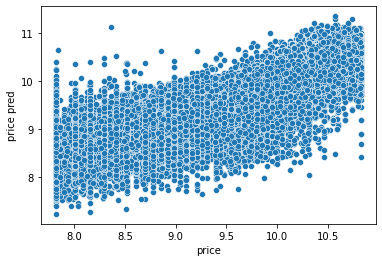

In [172]:
rmse = np.sqrt(mse(result_df['price'], result_df['price pred']))

print("Linear Regression with", "RMSE = {:.2f}".format(rmse))

ax = sns.scatterplot(x="price", y="price pred", data=result_df)
ax.get_xaxis().get_major_formatter().set_scientific(False)

# **Decision Tree Classifier**

DecisionTreeRegressor with max_depth= 15  rmse= 0.2849708959759044


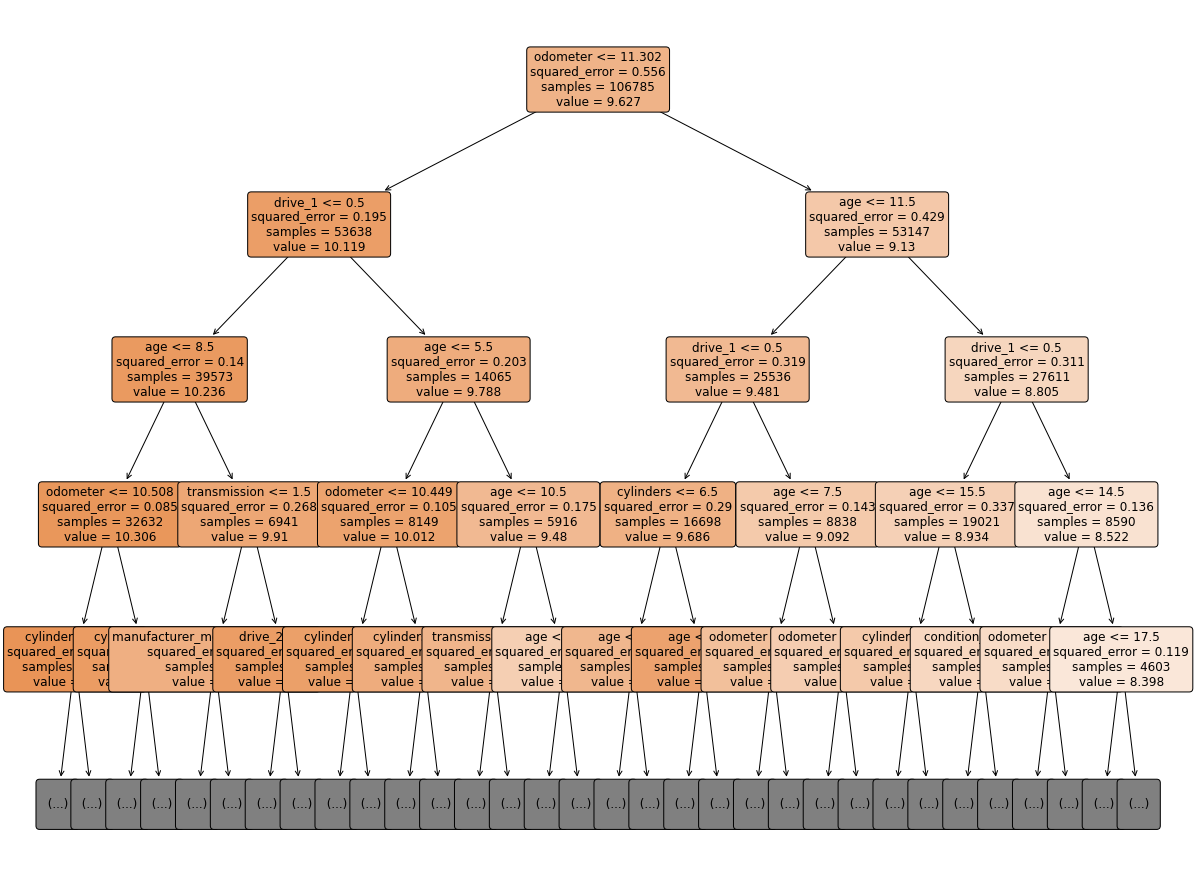

In [177]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score

t_max_depth=15

model_DTR = DecisionTreeRegressor(max_depth=t_max_depth)
model_DTR.fit(X_train, y_train)
y_pred = model_DTR.predict(X_test)

score = model_DTR.score(X_test, y_test)
# print("DecisionTreeRegressor with max_depth=",t_max_depth," score=", score)
error = sqrt(mse(y_test, y_pred)) #calculate rmse
print("DecisionTreeRegressor with max_depth=",t_max_depth," rmse=", error)

def visualize_tree(model, md=5, fs=(20, 16)):
    plt.figure(figsize=fs)
    tree.plot_tree(model,
            max_depth=md,
            feature_names=model.feature_names_in_,
            label='all',
            filled=True,
            rounded=True, 
            fontsize=12);

visualize_tree(model_DTR, md=4)

# **Random Forest Regressor**

In [178]:
# Random Forest Regressor
from sklearn.tree import export_graphviz
from IPython import display
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

t_max_depth = 15

rfmodel = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=t_max_depth)
rfmodel.fit(X_train, y_train)

y_pred = rfmodel.predict(X_test)

# print("RandomForestRegressor train score", rfmodel.score(X_train, y_train))
# print("RandomForestRegressor test score",rfmodel.score(X_test, y_test))

error = sqrt(mse(y_test, y_pred)) #calculate rmse
print("RandomForestRegressor with max_depth=",t_max_depth," rmse=", error)

RandomForestRegressor with max_depth= 15  rmse= 0.2401322027900871
